### 1. Load up datasets for 3 months
This project will be using the first quarter 2024 data. 

In [1]:
# Load parquet file into dataframe
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from lightgbm import LGBMRegressor
import xgboost as xgb

Reuseable function to load required columns from parquet file

In [2]:
# Load file and ensure columns are in format to ease processing
def process_parquet(parquet_file_path, sample_frac=0.01):
    columns_needed = ['request_datetime', 'on_scene_datetime', 'PULocationID', 'DOLocationID', 'trip_time']

    # Read the specific columns
    df = pd.read_parquet(parquet_file_path, columns=columns_needed)
    
    # Sample a fraction of the dataframe to reduce memory usage and make processing faster
    sampled_df = df.sample(frac=sample_frac)
    
    # Convert datetime columns
    sampled_df['request_datetime'] = pd.to_datetime(sampled_df['request_datetime'])
    sampled_df['on_scene_datetime'] = pd.to_datetime(sampled_df['on_scene_datetime'])

    # Convert to second precision to save memory
    sampled_df['request_datetime'] = sampled_df['request_datetime'].values.astype('datetime64[s]')
    sampled_df['on_scene_datetime'] = sampled_df['on_scene_datetime'].values.astype('datetime64[s]')

    # Convert int64 to int32
    sampled_df['trip_time'] = sampled_df['trip_time'].astype('int32')
    
    # Calculate the wait_time in seconds
    sampled_df['wait_time'] = (sampled_df['on_scene_datetime'] - sampled_df['request_datetime']).dt.total_seconds()
    sampled_df['wait_time'] = sampled_df['wait_time'].astype('float32')
    
    return sampled_df

In [3]:
# Jan 2024
trip_jan = process_parquet('data/fhvhv_tripdata_2024-01.parquet')
trip_jan.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
1616656,2024-01-04 00:30:15,NaT,17,35,825,NaN
5642191,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0
11188893,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0
3982665,2024-01-07 19:52:45,NaT,79,145,1002,NaN
15479571,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0


In [4]:
# Feb 2024
trip_feb = process_parquet('data/fhvhv_tripdata_2024-02.parquet') 
trip_feb.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
16567064,2024-02-25 17:30:06,2024-02-25 17:33:39,79,40,1456,213.0
12727997,2024-02-19 21:50:58,2024-02-19 22:00:05,132,87,2425,547.0
17081172,2024-02-26 14:06:21,NaT,95,56,591,NaN
886510,2024-02-02 11:47:31,NaT,7,41,1431,NaN
19073716,2024-02-29 15:50:23,2024-02-29 16:02:30,108,39,2821,727.0


In [5]:
# Mar 2024
trip_mar = process_parquet('data/fhvhv_tripdata_2024-03.parquet') 
trip_mar.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
3587049,2024-03-06 05:15:35,NaT,148,138,1162,NaN
14192648,2024-03-21 18:55:46,2024-03-21 19:02:00,25,177,1765,374.0
12592925,2024-03-19 09:23:16,2024-03-19 09:28:46,72,61,1059,330.0
7708305,2024-03-11 19:09:37,2024-03-11 19:10:42,160,198,430,65.0
13408425,2024-03-20 16:16:09,2024-03-20 16:17:17,87,209,399,68.0


In [6]:
# Merge the three dataframes, ensure the merge is optimised
trips = pd.concat([trip_jan, trip_feb, trip_mar], ignore_index=True)

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-04 00:30:15,NaT,17,35,825,NaN
1,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0
2,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0
3,2024-01-07 19:52:45,NaT,79,145,1002,NaN
4,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0


In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603038 entries, 0 to 603037
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   603038 non-null  datetime64[s]
 1   on_scene_datetime  445434 non-null  datetime64[s]
 2   PULocationID       603038 non-null  int32        
 3   DOLocationID       603038 non-null  int32        
 4   trip_time          603038 non-null  int32        
 5   wait_time          445434 non-null  float32      
dtypes: datetime64[s](2), float32(1), int32(3)
memory usage: 18.4 MB


### 2. Data Exploration

In [8]:
# Shape of dataframe
trips.shape

(603038, 6)

In [9]:
trips.describe()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
count,603038,445434,603038.000000,603038.000000,603038.000000,445434.000000
mean,2024-02-16 10:34:49,2024-02-16 12:38:46,138.661841,142.071521,1148.144956,191.754822
min,2023-12-31 23:57:34,2023-12-31 23:59:34,2.000000,1.000000,1.000000,-6797.000000
25%,2024-01-24 22:50:21,2024-01-25 07:15:48,75.000000,76.000000,584.000000,96.000000
50%,2024-02-16 18:26:05,2024-02-16 16:48:12,140.000000,141.000000,939.000000,163.000000
75%,2024-03-09 18:27:04,2024-03-09 20:30:21,210.000000,216.000000,1478.000000,259.000000
max,2024-03-31 23:56:45,2024-03-31 23:58:48,265.000000,265.000000,31675.000000,11095.000000
std,NaN,NaN,74.854381,77.727211,810.949109,190.847580


In [10]:
# Check for nulls
trips.isnull().sum()

request_datetime          0
on_scene_datetime    157604
PULocationID              0
DOLocationID              0
trip_time                 0
wait_time            157604
dtype: int64

In [11]:
# Drop nulls there is more than enough data
trips = trips.dropna()
trips.shape

(445434, 6)

<Axes: xlabel='wait_time'>

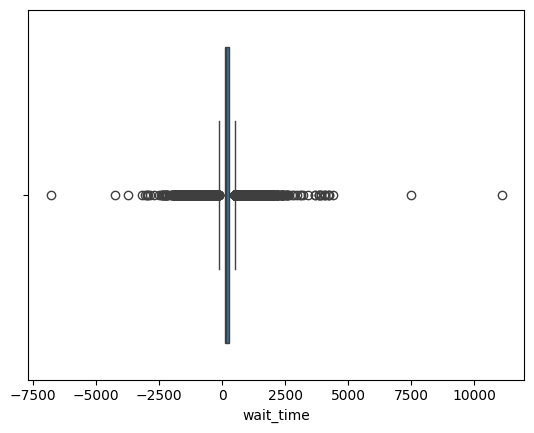

In [12]:
# Wait time seems to have some negative values from the min. Using boxplot to investigate more
sns.boxplot(x=trips['wait_time'])

In [13]:
# Get the count of negative wait times.
trips[trips['wait_time'] < 0]['wait_time'].count()

4006

In [14]:
# Drop negative wait times
trips = trips[trips['wait_time'] >= 0]

trips.shape

(441428, 6)

### 3. Add external data and features
#### 3.1. Add Holidays in NYC data

In [15]:
# Holidays
from datetime import date
import holidays

ny_holidays = holidays.country_holidays('US', subdiv='NY', years=2024)

# Load ny_holidays into dataframe, date and holiday name
ny_holidays_df = pd.DataFrame.from_dict(ny_holidays, orient='index')
ny_holidays_df

,0
2024-01-01,New Year's Day
2024-05-27,Memorial Day
2024-06-19,Juneteenth National Independence Day
2024-07-04,Independence Day
2024-09-02,Labor Day
2024-11-11,Veterans Day
2024-11-28,Thanksgiving
2024-12-25,Christmas Day
2024-01-15,Martin Luther King Jr. Day
2024-02-19,Washington's Birthday


In [16]:
# Reset index and rename columns
ny_holidays_df.reset_index(inplace=True)
ny_holidays_df.columns = ['date', 'holiday_name']
ny_holidays_df

,date,holiday_name
0,2024-01-01,New Year's Day
1,2024-05-27,Memorial Day
2,2024-06-19,Juneteenth National Independence Day
3,2024-07-04,Independence Day
4,2024-09-02,Labor Day
5,2024-11-11,Veterans Day
6,2024-11-28,Thanksgiving
7,2024-12-25,Christmas Day
8,2024-01-15,Martin Luther King Jr. Day
9,2024-02-19,Washington's Birthday


In [17]:
# Convert holidays to datetime and create is_holiday flag in the trips dataframe
ny_holidays_df.index = pd.to_datetime(ny_holidays_df.index)
ny_holidays_df['date'].values.astype('datetime64[s]')
trips['is_holiday'] = trips['request_datetime'].dt.date.isin(ny_holidays_df['date']).astype(int)
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday
1,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0,0
2,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0,0
4,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0,0
6,2024-01-18 20:16:52,2024-01-18 20:26:07,230,261,1266,555.0,0
7,2024-01-31 18:59:42,2024-01-31 19:01:36,243,167,1845,114.0,0


In [18]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441428 entries, 1 to 603037
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   441428 non-null  datetime64[s]
 1   on_scene_datetime  441428 non-null  datetime64[s]
 2   PULocationID       441428 non-null  int32        
 3   DOLocationID       441428 non-null  int32        
 4   trip_time          441428 non-null  int32        
 5   wait_time          441428 non-null  float32      
 6   is_holiday         441428 non-null  int32        
dtypes: datetime64[s](2), float32(1), int32(4)
memory usage: 18.5 MB


#### 3.2. Add Time Based Features

In [19]:
# Hour of the day, day of the week, month, year
trips['hour'] = trips['request_datetime'].dt.hour
trips['week_day'] = trips['request_datetime'].dt.weekday
trips['week_number'] = trips['request_datetime'].dt.isocalendar().week
trips['month'] = trips['request_datetime'].dt.month

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month
1,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0,0,18,2,2,1
2,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0,0,7,4,3,1
4,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0,0,16,3,4,1
6,2024-01-18 20:16:52,2024-01-18 20:26:07,230,261,1266,555.0,0,20,3,3,1
7,2024-01-31 18:59:42,2024-01-31 19:01:36,243,167,1845,114.0,0,18,2,5,1


In [20]:
# Define total trip time
trips['total_trip_time'] = trips['wait_time'] + trips['trip_time']
trips['total_trip_time'] = trips['wait_time'].astype('float32')
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time
1,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0,0,18,2,2,1,248.0
2,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0,0,7,4,3,1,392.0
4,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0,0,16,3,4,1,257.0
6,2024-01-18 20:16:52,2024-01-18 20:26:07,230,261,1266,555.0,0,20,3,3,1,555.0
7,2024-01-31 18:59:42,2024-01-31 19:01:36,243,167,1845,114.0,0,18,2,5,1,114.0


In [21]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441428 entries, 1 to 603037
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype        
---  ------             --------------   -----        
 0   request_datetime   441428 non-null  datetime64[s]
 1   on_scene_datetime  441428 non-null  datetime64[s]
 2   PULocationID       441428 non-null  int32        
 3   DOLocationID       441428 non-null  int32        
 4   trip_time          441428 non-null  int32        
 5   wait_time          441428 non-null  float32      
 6   is_holiday         441428 non-null  int32        
 7   hour               441428 non-null  int32        
 8   week_day           441428 non-null  int32        
 9   week_number        441428 non-null  UInt32       
 10  month              441428 non-null  int32        
 11  total_trip_time    441428 non-null  float32      
dtypes: UInt32(1), datetime64[s](2), float32(2), int32(7)
memory usage: 27.4 MB


#### 3.3. Group into Peak, off-peak and night time

In [22]:
""" 
    Group request datetime into Peak, Off-Peak and Night
    Night: 10pm to 6am
    Off-Peak: Weekdays, 10am to 3pm and 7pm to 10pm. Weekends, 6am to 10pm
    Peak: Weekdays, 6am to 10am and 3pm to 7pm
"""

# Extract hour and day of week
hour = trips['hour']
week_day = trips['week_day']

# is holiday
is_holiday = trips['is_holiday'].astype(bool)

# Initialize the default group as Night (0)
trips['request_time_group'] = 0

# Define conditions for Peak (2) and OffPeak (1) times for weekday
weekday_mask = week_day < 5

peak_mask = (hour >= 6) & (hour < 10) | (hour >= 15) & (hour < 19)
off_peak_mask = (hour >= 10) & (hour < 15) | (hour >= 19) & (hour < 22)

# For weekend
weekend_mask = ~weekday_mask

# Apply conditions for weekdays
# Pandas is built to work efficiently with data in a vectorized way, meaning it can operate on entire columns (or Series) of data at once without needing an explicit loop
# .loc leverages the underlying numpy array to apply the mask to the dataframe without iterating over rows one by one
# note that all day during holidays are Off-Peak

# If day is not holiday, it will be Peak
trips.loc[weekday_mask & peak_mask & ~is_holiday, 'request_time_group'] = 2
# If day is holiday, it will be Off-Peak
trips.loc[weekday_mask & peak_mask & is_holiday, 'request_time_group'] = 1

trips.loc[weekday_mask & off_peak_mask, 'request_time_group'] = 1

# Apply conditions for weekends
trips.loc[weekend_mask & (hour >= 6) & (hour < 22), 'request_time_group'] = 1

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time,request_time_group
1,2024-01-10 18:41:24,2024-01-10 18:45:32,220,200,406,248.0,0,18,2,2,1,248.0,2
2,2024-01-19 07:04:45,2024-01-19 07:11:17,117,170,4343,392.0,0,7,4,3,1,392.0,2
4,2024-01-25 16:06:08,2024-01-25 16:10:25,170,107,342,257.0,0,16,3,4,1,257.0,2
6,2024-01-18 20:16:52,2024-01-18 20:26:07,230,261,1266,555.0,0,20,3,3,1,555.0,1
7,2024-01-31 18:59:42,2024-01-31 19:01:36,243,167,1845,114.0,0,18,2,5,1,114.0,2


In [23]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441428 entries, 1 to 603037
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    441428 non-null  datetime64[s]
 1   on_scene_datetime   441428 non-null  datetime64[s]
 2   PULocationID        441428 non-null  int32        
 3   DOLocationID        441428 non-null  int32        
 4   trip_time           441428 non-null  int32        
 5   wait_time           441428 non-null  float32      
 6   is_holiday          441428 non-null  int32        
 7   hour                441428 non-null  int32        
 8   week_day            441428 non-null  int32        
 9   week_number         441428 non-null  UInt32       
 10  month               441428 non-null  int32        
 11  total_trip_time     441428 non-null  float32      
 12  request_time_group  441428 non-null  int64        
dtypes: UInt32(1), datetime64[s](2), float32(2), int32

In [24]:
# Drop unneeded columns
trips.drop(['on_scene_datetime'], axis=1, inplace=True)

trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,total_trip_time,request_time_group
1,2024-01-10 18:41:24,220,200,406,248.0,0,18,2,2,1,248.0,2
2,2024-01-19 07:04:45,117,170,4343,392.0,0,7,4,3,1,392.0,2
4,2024-01-25 16:06:08,170,107,342,257.0,0,16,3,4,1,257.0,2
6,2024-01-18 20:16:52,230,261,1266,555.0,0,20,3,3,1,555.0,1
7,2024-01-31 18:59:42,243,167,1845,114.0,0,18,2,5,1,114.0,2


In [25]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441428 entries, 1 to 603037
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype        
---  ------              --------------   -----        
 0   request_datetime    441428 non-null  datetime64[s]
 1   PULocationID        441428 non-null  int32        
 2   DOLocationID        441428 non-null  int32        
 3   trip_time           441428 non-null  int32        
 4   wait_time           441428 non-null  float32      
 5   is_holiday          441428 non-null  int32        
 6   hour                441428 non-null  int32        
 7   week_day            441428 non-null  int32        
 8   week_number         441428 non-null  UInt32       
 9   month               441428 non-null  int32        
 10  total_trip_time     441428 non-null  float32      
 11  request_time_group  441428 non-null  int64        
dtypes: UInt32(1), datetime64[s](1), float32(2), int32(7), int64(1)
memory usage: 27.4 MB


#### 3.4. NYC weather

In [26]:
# Get Weather data
from datetime import datetime 
from meteostat import Point, Hourly, units  
# Set time period 
start = datetime(2024, 1, 1) 
end = datetime(2024, 3, 31)  
# Create Point for NY
location = Point(40.712775, -74.005973)  
# Get daily data 
weather_data = Hourly(location, start, end) 
weather_data = weather_data.convert(units.imperial) 
weather_data = weather_data.fetch()

weather_data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [27]:
# Reset index and convert time to datetime
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'index': 'time'}, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2,2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
3,2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
4,2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [28]:
# Create column to compare with weather time
trips['rounded_request_datetime'] = trips['request_datetime'].dt.round('H')

In [29]:
# Merge trips and weather dataframe on trips[rounded_request_datetime] and weather[time]
trips = trips.merge(weather_data, left_on='rounded_request_datetime', right_on='time', how='left')
trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,week_number,month,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-10 18:41:24,220,200,406,248.0,0,18,2,2,1,...,28.8,49.0,0.000,NaN,270.0,23.1,NaN,996.0,NaN,3.0
1,2024-01-19 07:04:45,117,170,4343,392.0,0,7,4,3,1,...,19.9,58.0,0.000,NaN,80.0,5.8,NaN,1014.5,NaN,3.0
2,2024-01-25 16:06:08,170,107,342,257.0,0,16,3,4,1,...,48.0,93.0,0.016,NaN,210.0,5.8,NaN,1020.8,NaN,5.0
3,2024-01-18 20:16:52,230,261,1266,555.0,0,20,3,3,1,...,16.0,49.0,0.000,NaN,210.0,9.2,NaN,1019.6,NaN,3.0
4,2024-01-31 18:59:42,243,167,1845,114.0,0,18,2,5,1,...,31.1,73.0,0.000,NaN,270.0,4.7,NaN,1020.2,NaN,3.0


In [30]:
# Remove unneeded columns
trips.drop(['request_datetime', 'rounded_request_datetime', 'trip_time', 'time', 'dwpt', 'rhum', 'wait_time', 'prcp','snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'temp'], axis=1, inplace=True)

In [31]:
# Change data types
trips['request_time_group'] = trips['request_time_group'].astype('int32')
trips['coco'] = trips['coco'].astype('float32')

# Rename coco to weather_condition_code  
trips.rename(columns={'coco': 'weather_condition_code'}, inplace=True)

In [32]:
# Check for null values
trips.isnull().sum()

PULocationID                 0
DOLocationID                 0
is_holiday                   0
hour                         0
week_day                     0
week_number                  0
month                        0
total_trip_time              0
request_time_group           0
weather_condition_code    4620
dtype: int64

In [33]:
# Drop null values
trips.dropna(inplace=True)

### 4. More EDA - Investigating features

In [34]:
#rounding up columns and converting to int32
trips['total_trip_time'] = np.ceil(trips['total_trip_time']).astype('int32')
trips['weather_condition_code'] = np.ceil(trips['weather_condition_code']).astype('int32')

#### 4.1 Visualisations to further analyse relationships

In [35]:
# Group by PULocationID, DOLocationID, and hour
grouped_location_time = trips.groupby(['PULocationID', 'DOLocationID', 'hour']).agg({
    'total_trip_time': ['mean', 'count', 'std']
}).reset_index()
grouped_location_time.columns = ['PULocationID', 'DOLocationID', 'hour', 'avg_trip_time', 'total_trips', 'std_trip_time']

In [36]:
# Group by week_day and weather_condition_code
grouped_day_weather = trips.groupby(['week_day', 'weather_condition_code']).agg({
    'total_trip_time': ['mean', 'count', 'std']
}).reset_index()
grouped_day_weather.columns = ['week_day', 'weather_condition_code', 'avg_trip_time', 'total_trips', 'std_trip_time']

In [37]:
# Group by month for time series analysis
grouped_monthly = trips.groupby(['month']).agg({'total_trip_time': 'mean'}).reset_index()
grouped_monthly.columns = ['month', 'avg_trip_time']

In [38]:
# Group by weather_condition_code for total trips analysis
grouped_weather = trips.groupby('weather_condition_code').agg({'total_trip_time': 'sum'}).reset_index()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


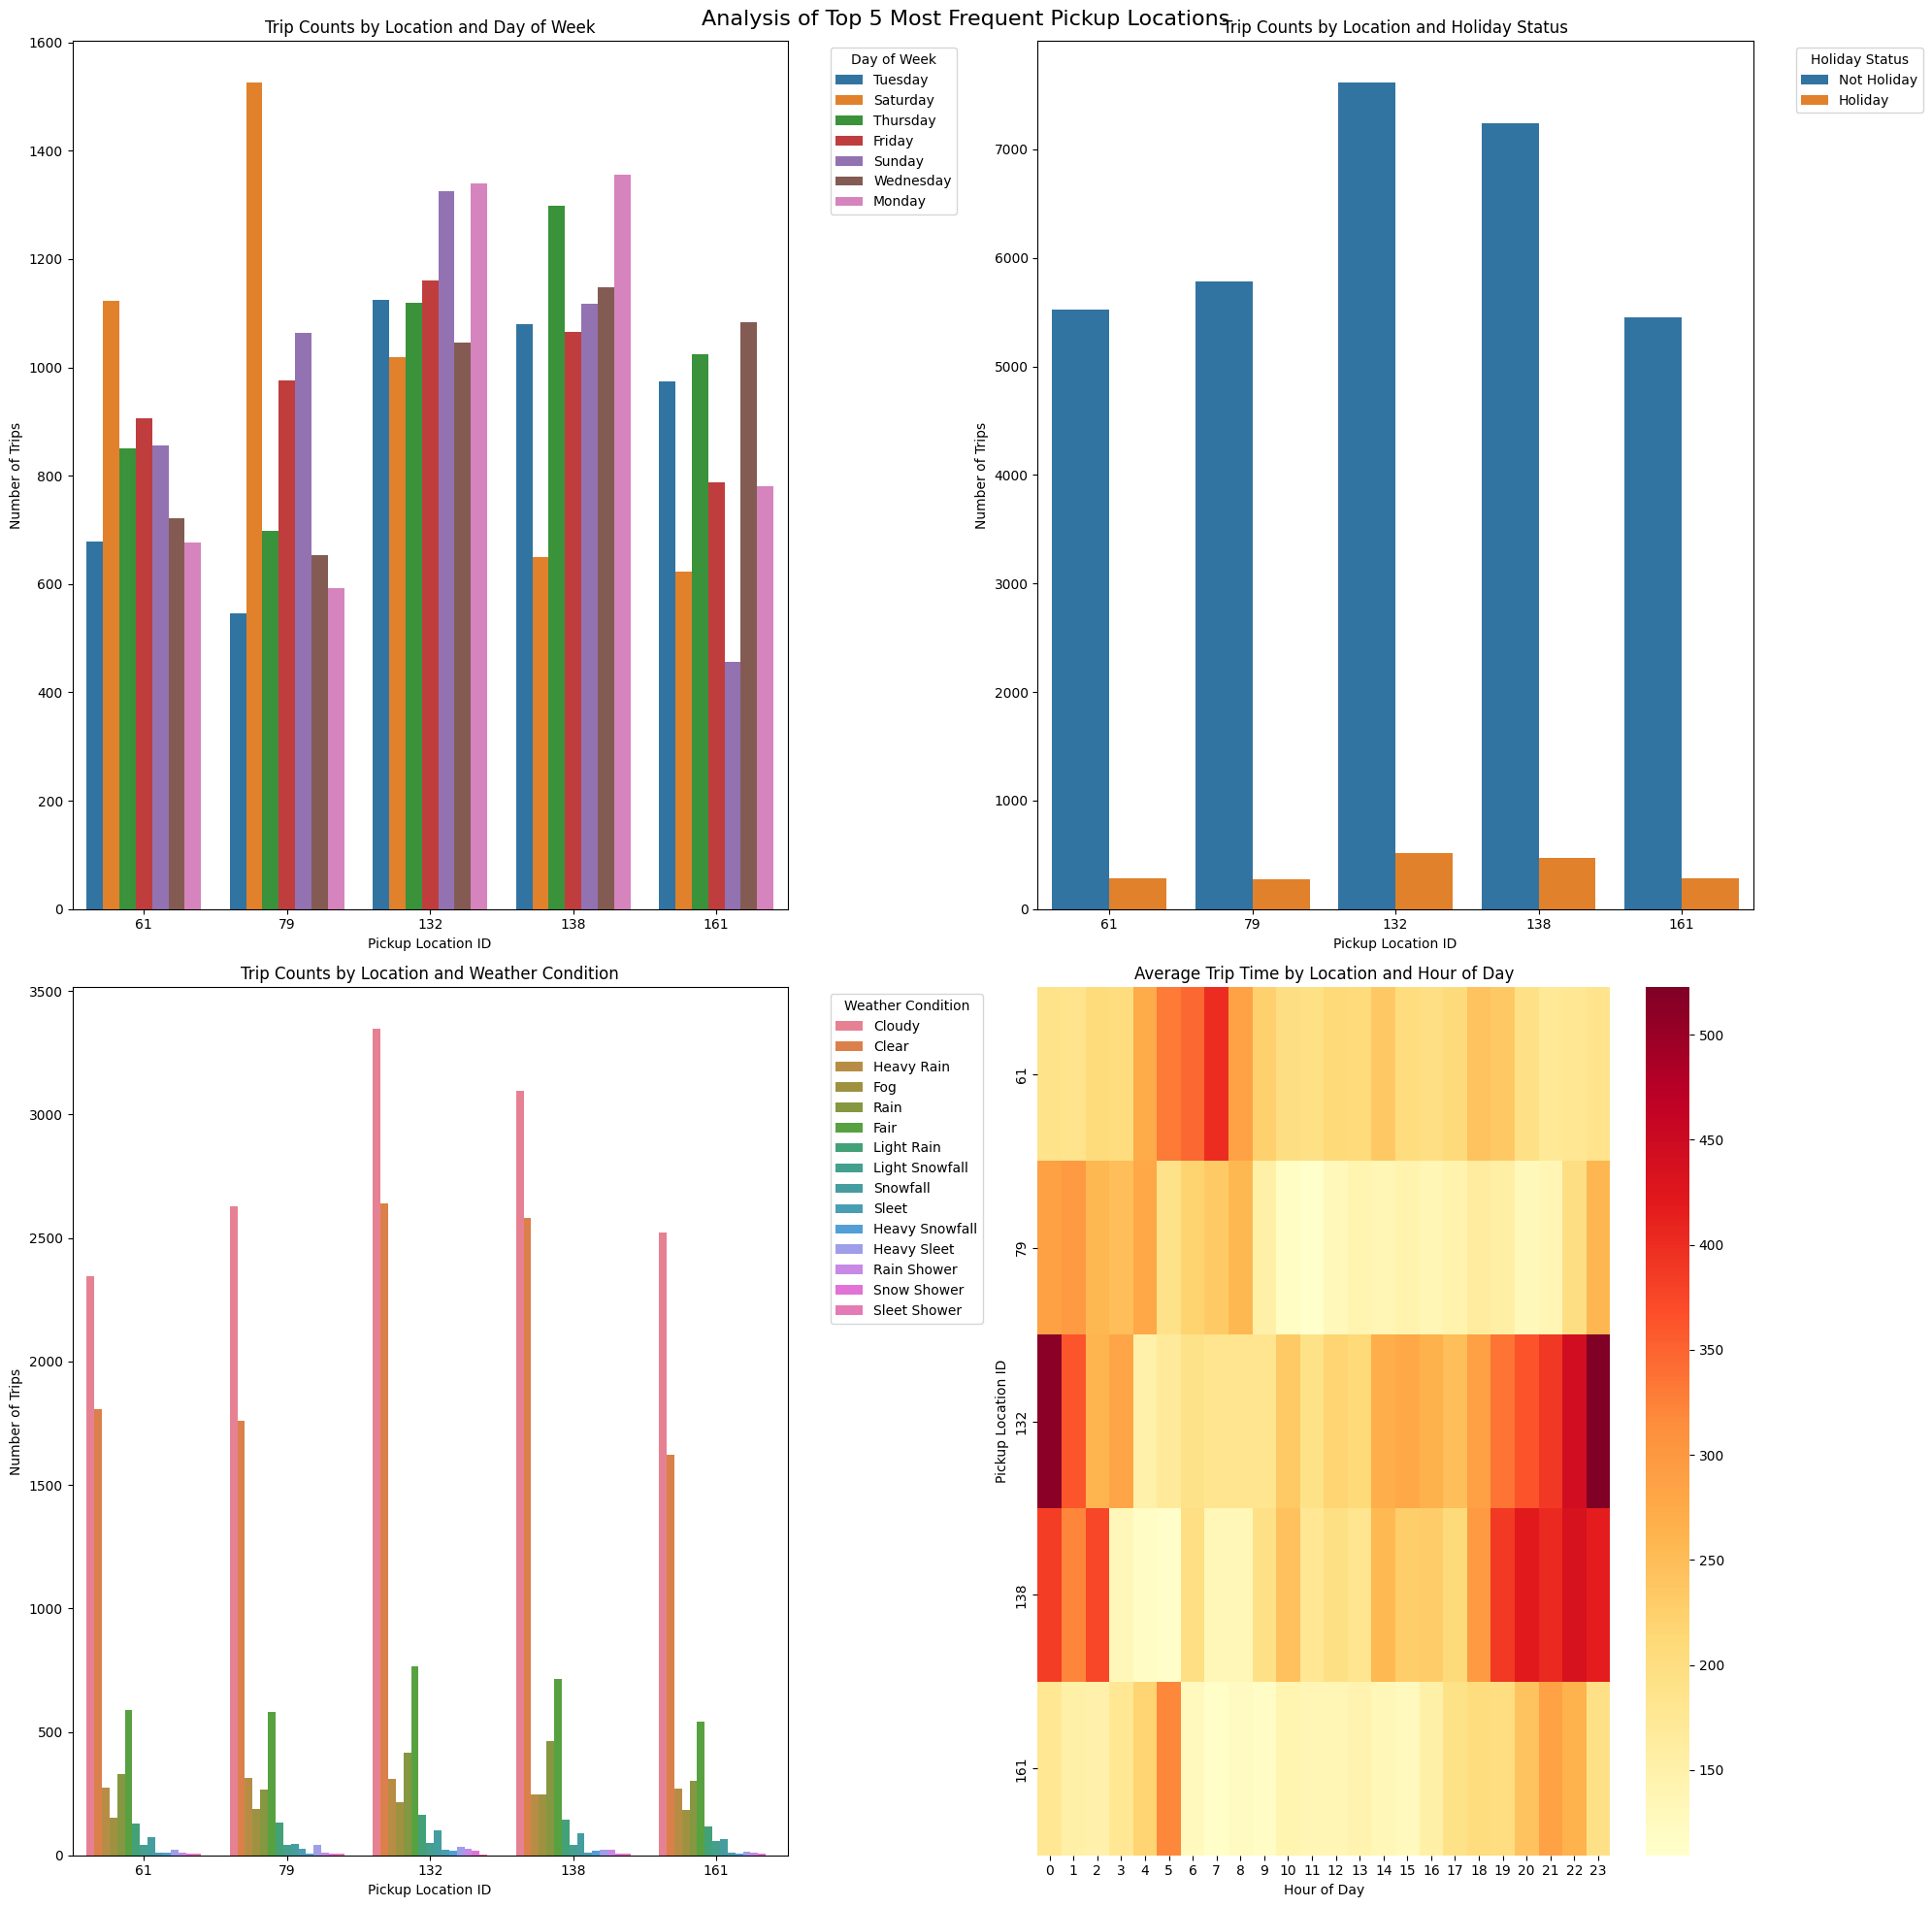


Summary Statistics for Top 5 Pickup Locations:

Pickup Location ID: 132
Total Trips: 8135
Average Trip Time: 309.89 seconds
Most Common Day: Monday
Most Common Weather: Cloudy
Percentage of Holiday Trips: 6.38%

Pickup Location ID: 138
Total Trips: 7714
Average Trip Time: 288.80 seconds
Most Common Day: Monday
Most Common Weather: Cloudy
Percentage of Holiday Trips: 6.13%

Pickup Location ID: 79
Total Trips: 6053
Average Trip Time: 188.99 seconds
Most Common Day: Saturday
Most Common Weather: Cloudy
Percentage of Holiday Trips: 4.54%

Pickup Location ID: 61
Total Trips: 5809
Average Trip Time: 222.96 seconds
Most Common Day: Saturday
Most Common Weather: Cloudy
Percentage of Holiday Trips: 4.85%

Pickup Location ID: 161
Total Trips: 5731
Average Trip Time: 188.20 seconds
Most Common Day: Wednesday
Most Common Weather: Cloudy
Percentage of Holiday Trips: 4.92%


In [39]:
# Get the top 5 most frequent pickup locations
top_5_locations = trips['PULocationID'].value_counts().nlargest(5).index

# Filter the DataFrame to include only these top 5 locations
df_top5 = trips[trips['PULocationID'].isin(top_5_locations)]

# Create a function to map weather condition codes to more readable labels
def weather_label(code):
    weather_codes = {
        1: "Clear",
        2: "Fair",
        3: "Cloudy",
        4: "Overcast",
        5: "Fog",
        6: "Freezing Fog",
        7: "Light Rain",
        8: "Rain",
        9: "Heavy Rain",
        10: "Freezing Rain",
        11: "Heavy Freezing Rain",
        12: "Sleet",
        13: "Heavy Sleet",
        14: "Light Snowfall",
        15: "Snowfall",
        16: "Heavy Snowfall",
        17: "Rain Shower",
        18: "Heavy Rain Shower",
        19: "Sleet Shower",
        20: "Heavy Sleet Shower",
        21: "Snow Shower",
        22: "Heavy Snow Shower",
        23: "Lightning",
        24: "Hail",
        25: "Thunderstorm",
        26: "Heavy Thunderstorm",
        27: "Storm"
    }
    return weather_codes.get(code, "Other")

# Apply the weather label function
df_top5['weather_label'] = df_top5['weather_condition_code'].apply(weather_label)

# Create a day of week column
df_top5['day_of_week'] = df_top5['week_day'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                                                  3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Create a holiday label column
df_top5['holiday_label'] = df_top5['is_holiday'].map({0: 'Not Holiday', 1: 'Holiday'})

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Analysis of Top 5 Most Frequent Pickup Locations', fontsize=16)

# 1. Bar plot of trip counts by location and day of week
sns.countplot(data=df_top5, x='PULocationID', hue='day_of_week', ax=axes[0, 0])
axes[0, 0].set_title('Trip Counts by Location and Day of Week')
axes[0, 0].set_xlabel('Pickup Location ID')
axes[0, 0].set_ylabel('Number of Trips')
axes[0, 0].legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Bar plot of trip counts by location and holiday status
sns.countplot(data=df_top5, x='PULocationID', hue='holiday_label', ax=axes[0, 1])
axes[0, 1].set_title('Trip Counts by Location and Holiday Status')
axes[0, 1].set_xlabel('Pickup Location ID')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].legend(title='Holiday Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Bar plot of trip counts by location and weather condition
sns.countplot(data=df_top5, x='PULocationID', hue='weather_label', ax=axes[1, 0])
axes[1, 0].set_title('Trip Counts by Location and Weather Condition')
axes[1, 0].set_xlabel('Pickup Location ID')
axes[1, 0].set_ylabel('Number of Trips')
axes[1, 0].legend(title='Weather Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Heatmap of average trip time by location and hour of day
pivot_table = df_top5.pivot_table(values='total_trip_time', index='PULocationID', columns='hour', aggfunc='mean')
sns.heatmap(pivot_table, cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Average Trip Time by Location and Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Pickup Location ID')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Top 5 Pickup Locations:")
for location in top_5_locations:
    location_data = df_top5[df_top5['PULocationID'] == location]
    print(f"\nPickup Location ID: {location}")
    print(f"Total Trips: {len(location_data)}")
    print(f"Average Trip Time: {location_data['total_trip_time'].mean():.2f} seconds")
    print(f"Most Common Day: {location_data['day_of_week'].mode().values[0]}")
    print(f"Most Common Weather: {location_data['weather_label'].mode().values[0]}")
    print(f"Percentage of Holiday Trips: {(location_data['is_holiday'].mean() * 100):.2f}%")

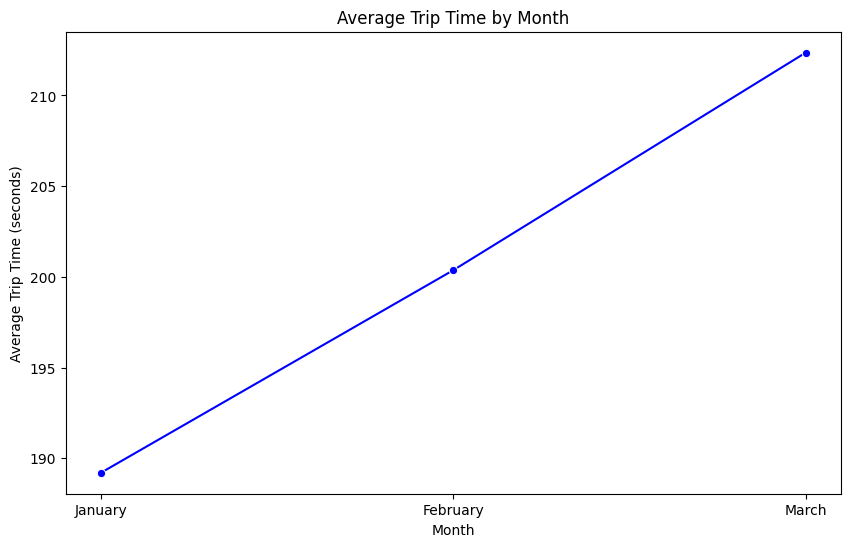

In [40]:
# Filter the data for the first 3 months
first_3_months = grouped_monthly[grouped_monthly['month'].isin([1, 2, 3])]

# Sort the data by month to ensure correct order
first_3_months = first_3_months.sort_values('month')

# Line plot of average trip time by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=first_3_months, x='month', y='avg_trip_time', marker="o", color="b")
plt.title('Average Trip Time by Month')
plt.xlabel('Month')
plt.ylabel('Average Trip Time (seconds)')

# Customize x-axis ticks to show month names
plt.xticks([1, 2, 3], ['January', 'February', 'March'])

plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



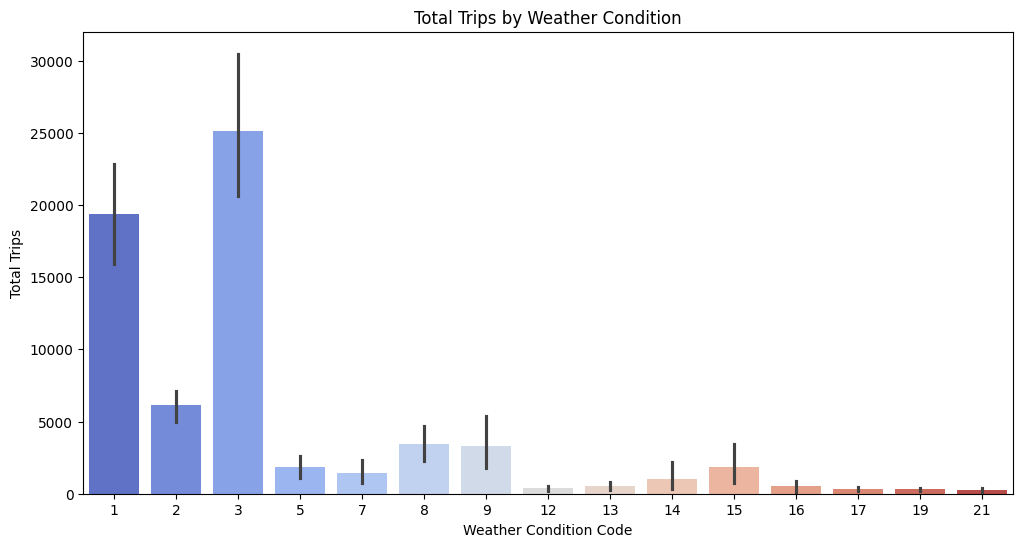

In [41]:
# Barplot of total trips by weather condition
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_day_weather, x='weather_condition_code', y='total_trips', palette="coolwarm")
plt.title('Total Trips by Weather Condition')
plt.xlabel('Weather Condition Code')
plt.ylabel('Total Trips')
plt.show()

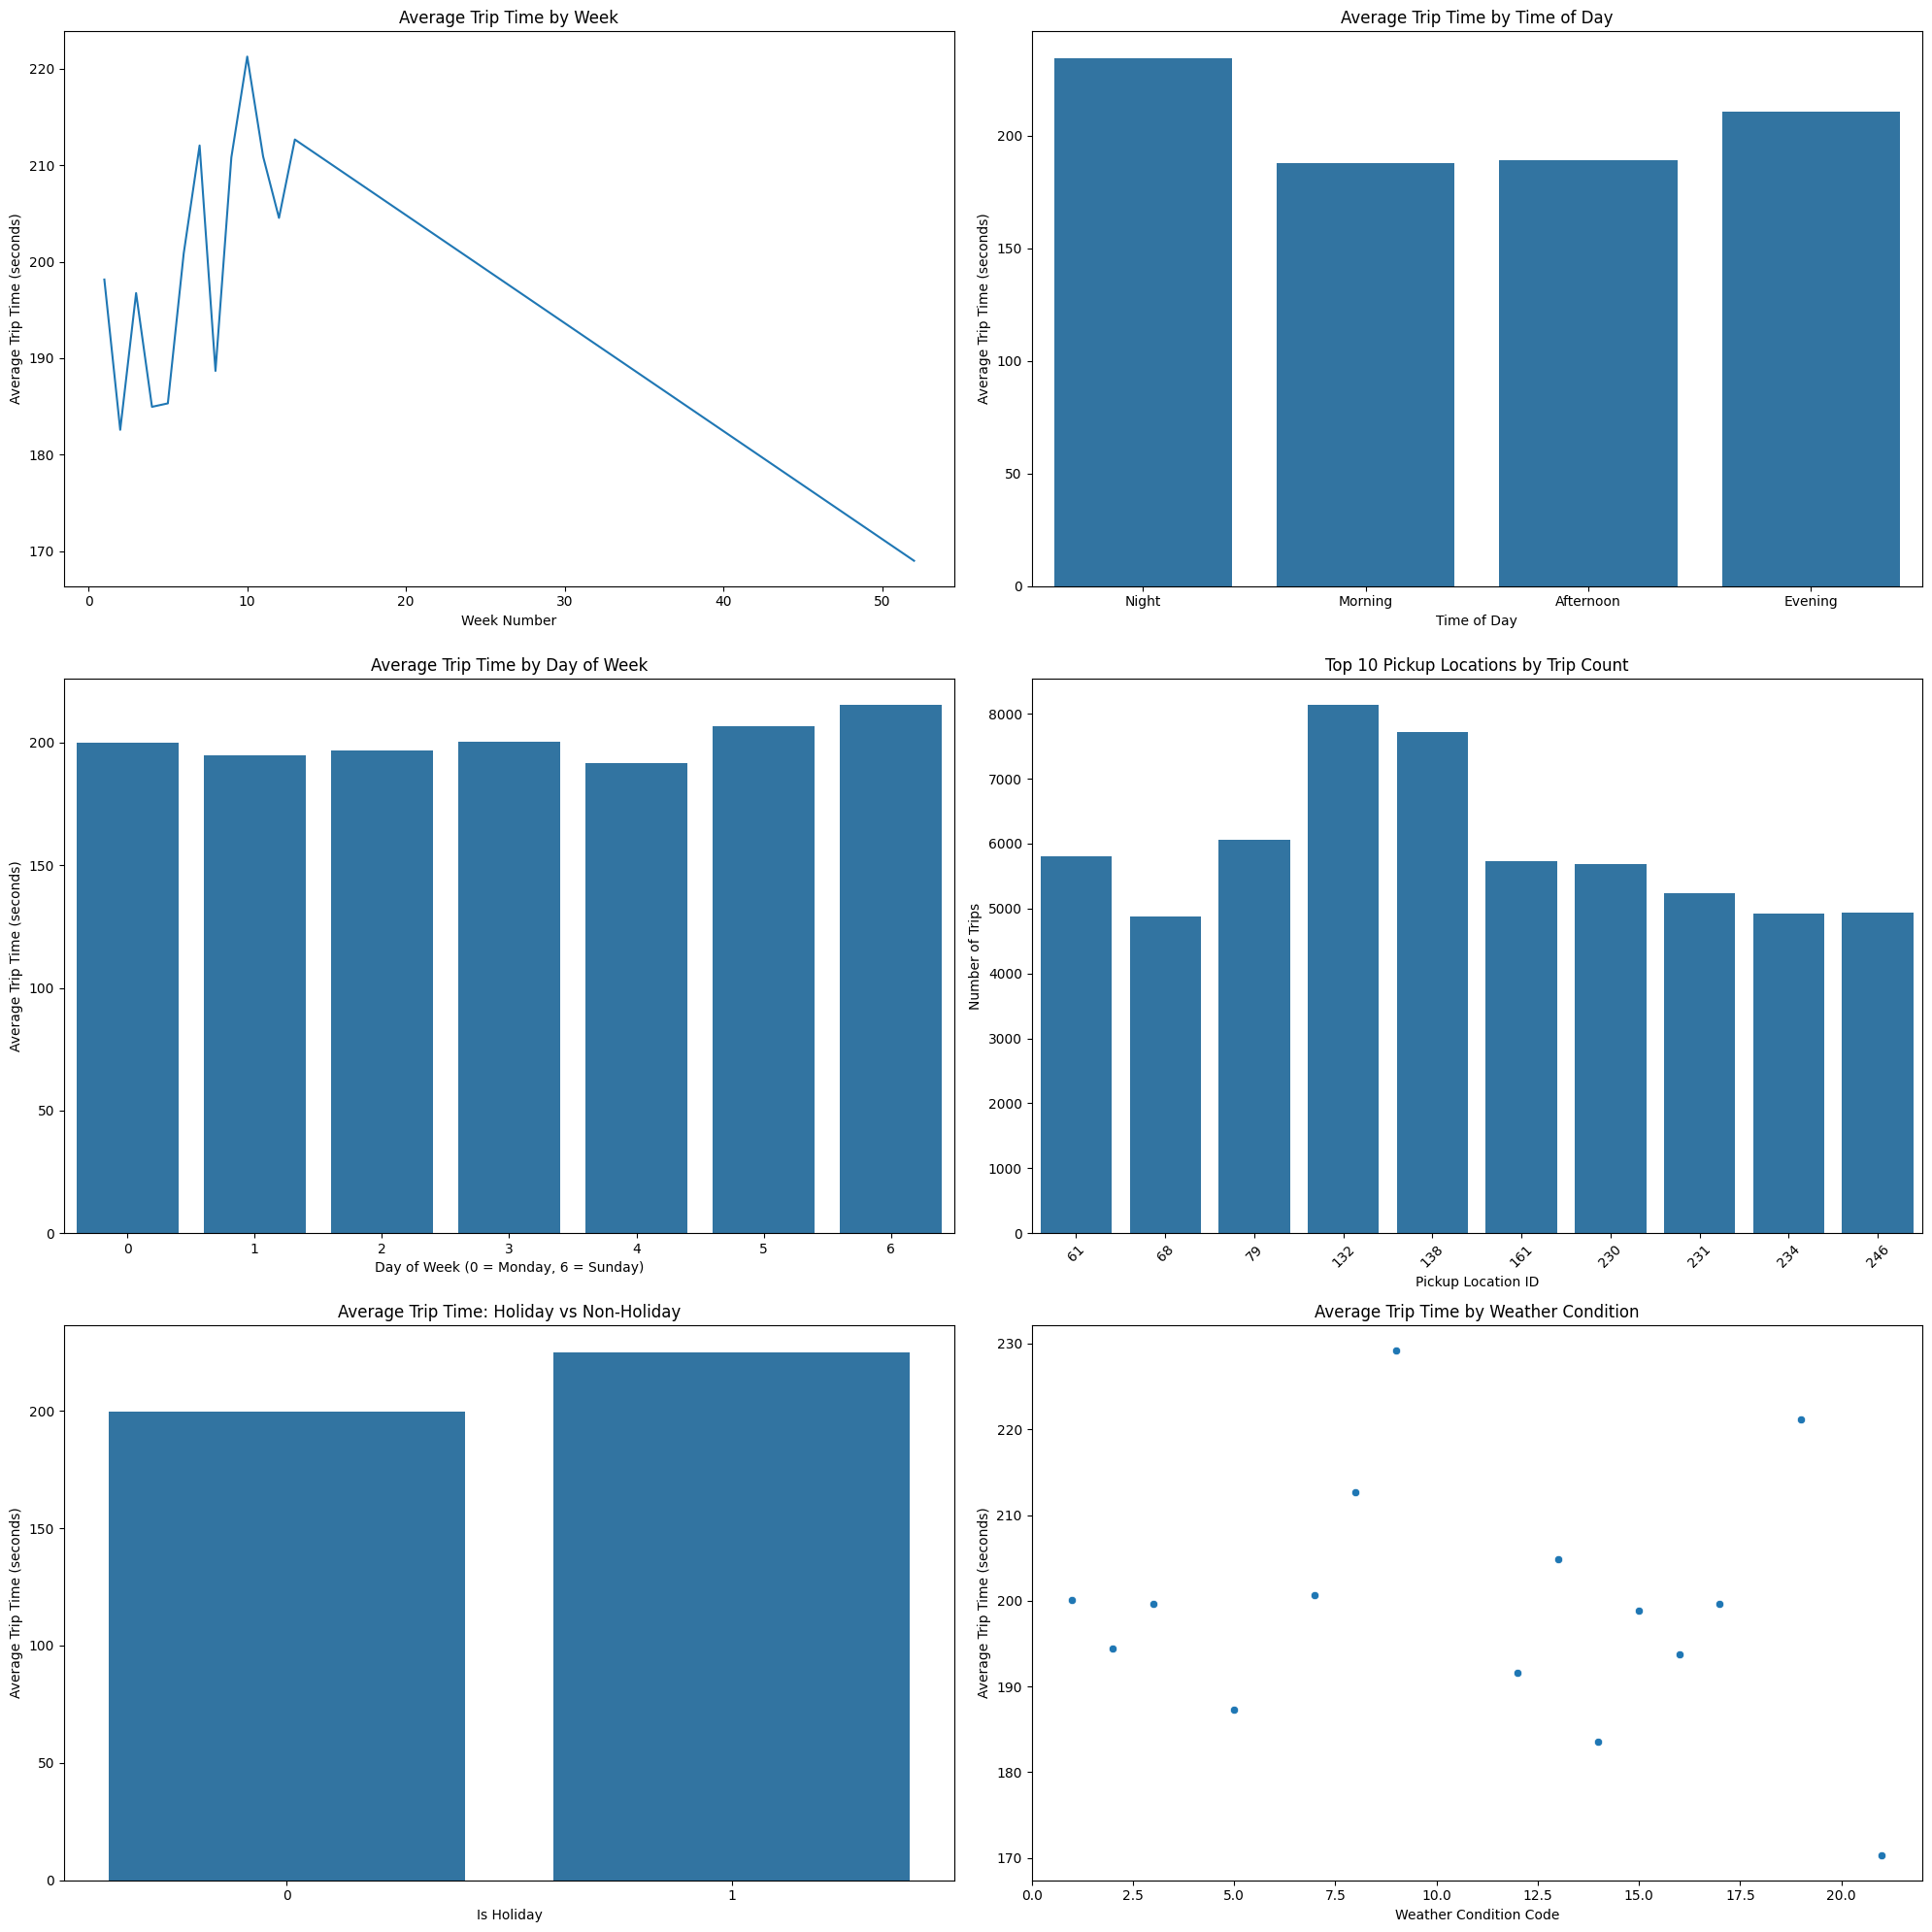

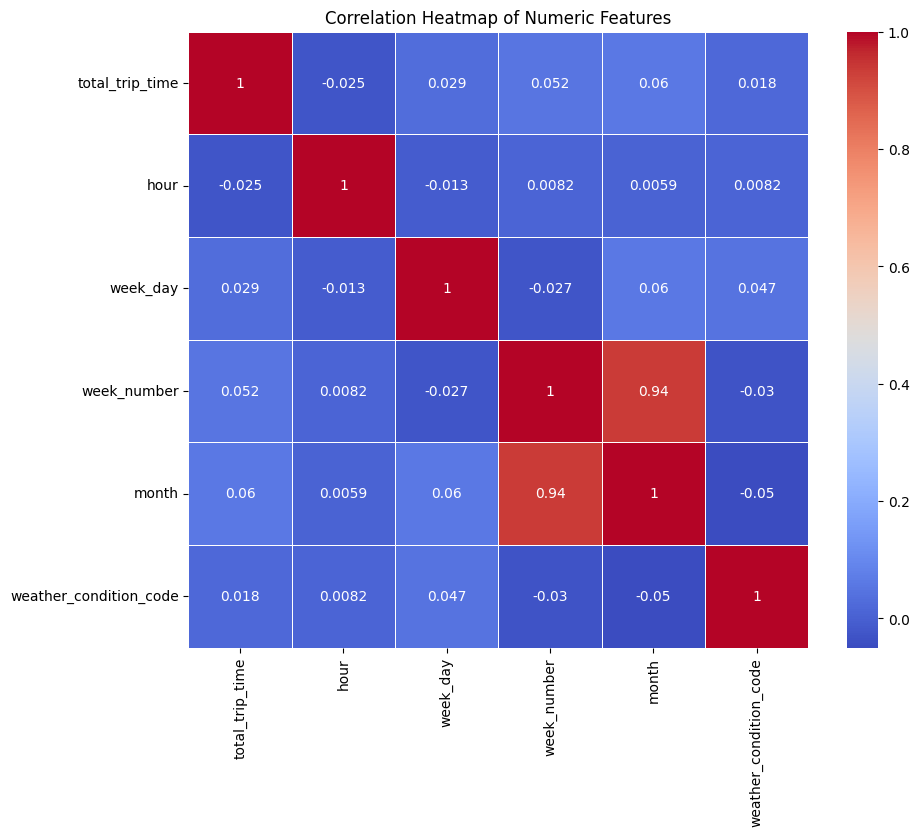

       week_number  total_trip_time  PULocationID   is_holiday  \
count         14.0        14.000000     14.000000    14.000000   
mean     10.214286       198.468186  31200.571429  1582.928571   
std      12.595351        14.756880   9188.831546  2900.175736   
min            1.0       169.000000      5.000000     0.000000   
25%           4.25       186.158094  32426.250000     0.000000   
50%            7.5       199.510606  34069.000000     0.000000   
75%          10.75       210.887603  34821.250000  2999.250000   
max           52.0       221.263461  35630.000000  9559.000000   

       weather_condition_code  trips_per_week  avg_trip_time  
count               14.000000       14.000000      14.000000  
mean                 3.356331    31200.571429     198.468186  
std                  0.814117     9188.831546      14.756880  
min                  2.146971        5.000000     169.000000  
25%                  2.931657    32426.250000     186.158094  
50%                  3.0769

In [42]:
# 1. Aggregate data by week
weekly_data = trips.groupby('week_number').agg({
    'total_trip_time': 'mean',
    'PULocationID': 'count',
    'is_holiday': 'sum',
    'weather_condition_code': 'mean'
}).reset_index()

weekly_data['trips_per_week'] = weekly_data['PULocationID']
weekly_data['avg_trip_time'] = weekly_data['total_trip_time']

# 2. Analyze trip duration by time of day
trips['hour_group'] = pd.cut(trips['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
time_of_day_data = trips.groupby('hour_group')['total_trip_time'].mean().reset_index()

# 3. Analyze trip duration by day of week
day_of_week_data = trips.groupby('week_day')['total_trip_time'].mean().reset_index()

# 4. Analyze trip counts by pickup location
location_data = trips['PULocationID'].value_counts().nlargest(10).reset_index()
location_data.columns = ['PULocationID', 'trip_count']

# 5. Analyze the effect of holidays on trip duration
holiday_effect = trips.groupby('is_holiday')['total_trip_time'].mean().reset_index()

# 6. Analyze the effect of weather on trip duration
weather_effect = trips.groupby('weather_condition_code')['total_trip_time'].mean().reset_index()

# Visualizations
plt.figure(figsize=(20, 20))

# 1. Weekly trend
plt.subplot(3, 2, 1)
sns.lineplot(data=weekly_data, x='week_number', y='avg_trip_time')
plt.title('Average Trip Time by Week')
plt.xlabel('Week Number')
plt.ylabel('Average Trip Time (seconds)')

# 2. Time of day analysis
plt.subplot(3, 2, 2)
sns.barplot(data=time_of_day_data, x='hour_group', y='total_trip_time')
plt.title('Average Trip Time by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Trip Time (seconds)')

# 3. Day of week analysis
plt.subplot(3, 2, 3)
sns.barplot(data=day_of_week_data, x='week_day', y='total_trip_time')
plt.title('Average Trip Time by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Trip Time (seconds)')

# 4. Top pickup locations
plt.subplot(3, 2, 4)
sns.barplot(data=location_data, x='PULocationID', y='trip_count')
plt.title('Top 10 Pickup Locations by Trip Count')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)

# 5. Holiday effect
plt.subplot(3, 2, 5)
sns.barplot(data=holiday_effect, x='is_holiday', y='total_trip_time')
plt.title('Average Trip Time: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Trip Time (seconds)')

# 6. Weather effect
plt.subplot(3, 2, 6)
sns.scatterplot(data=weather_effect, x='weather_condition_code', y='total_trip_time')
plt.title('Average Trip Time by Weather Condition')
plt.xlabel('Weather Condition Code')
plt.ylabel('Average Trip Time (seconds)')

plt.tight_layout()
plt.show()

# Additional analysis: Correlation heatmap
numeric_columns = ['total_trip_time', 'hour', 'week_day', 'week_number', 'month', 'weather_condition_code']
correlation_matrix = trips[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Print some summary statistics
print(weekly_data.describe())
print("\nTop 5 busiest pickup locations:")
print(location_data.head())
print("\nAverage trip time on holidays vs non-holidays:")
print(holiday_effect)

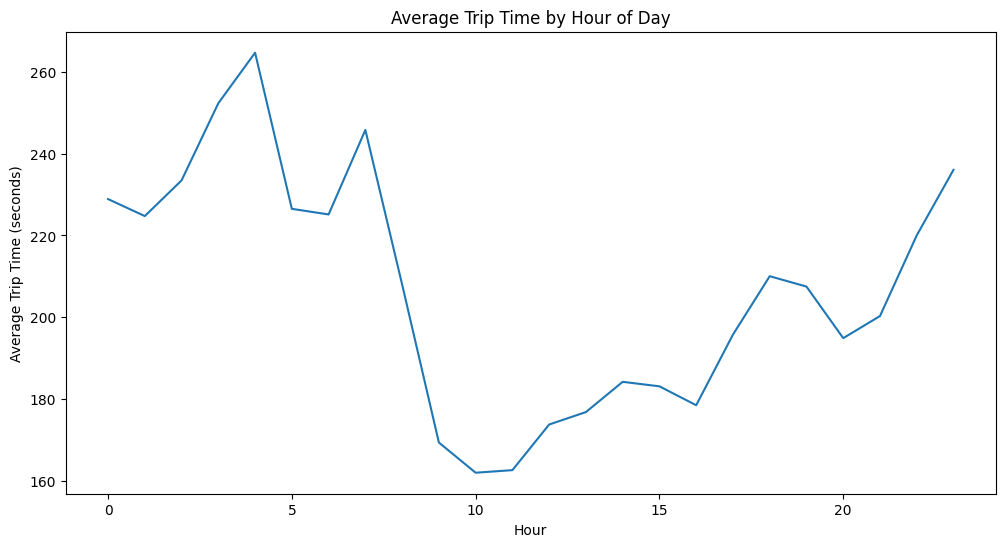

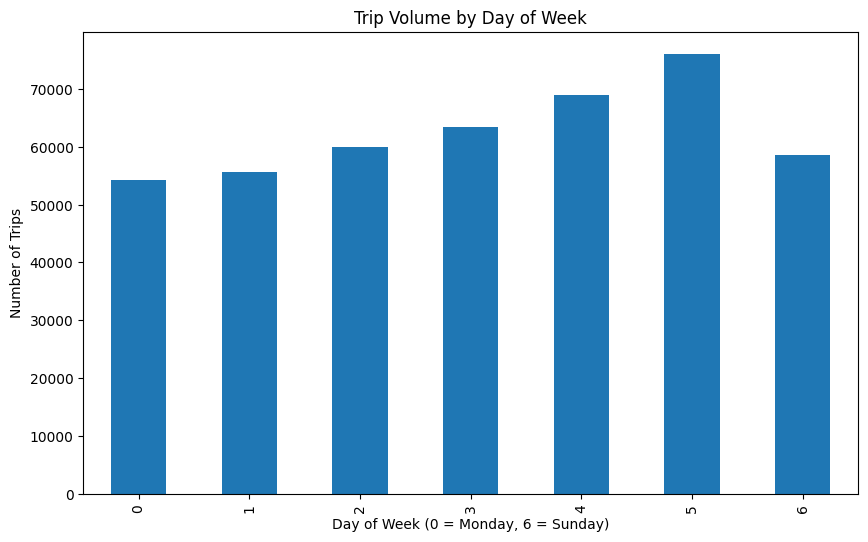

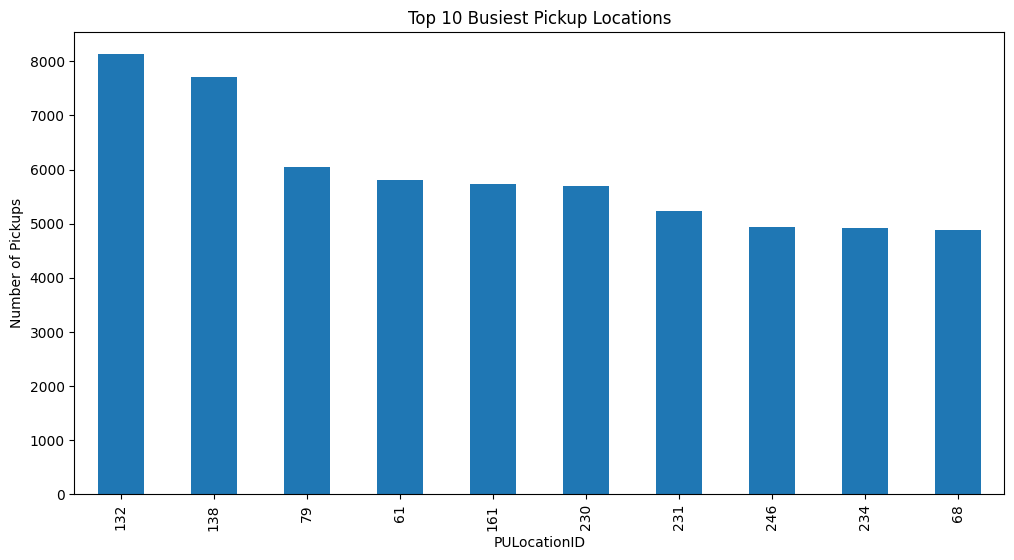

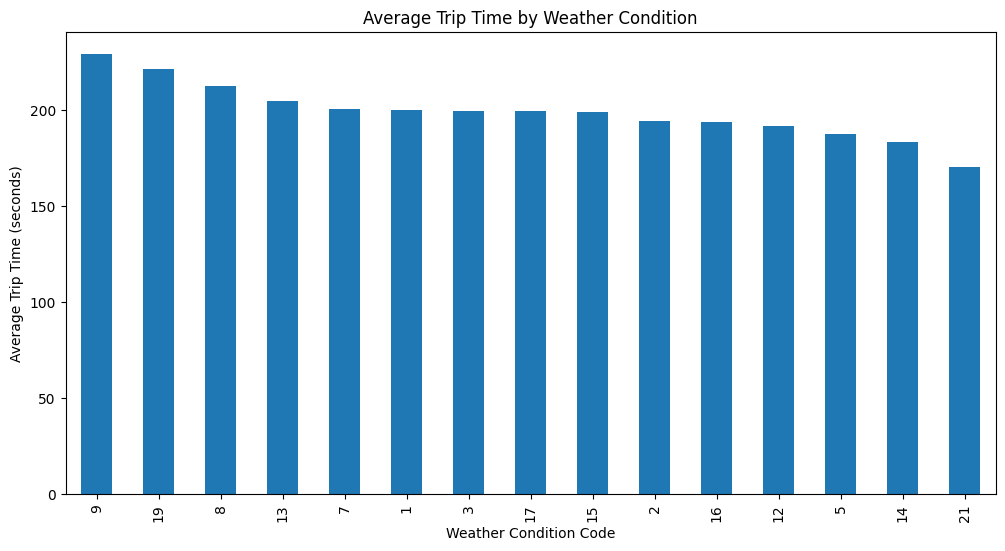

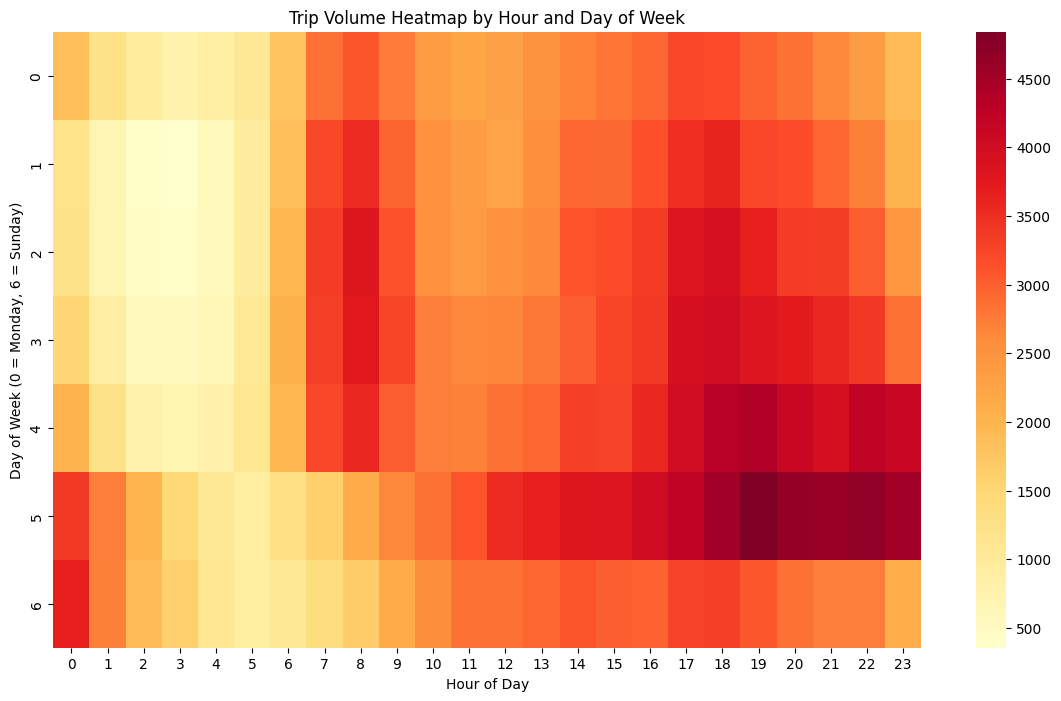

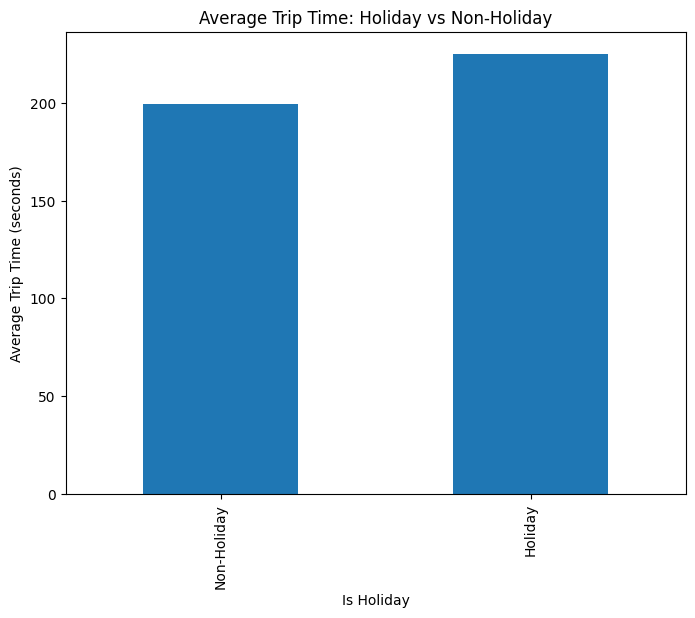

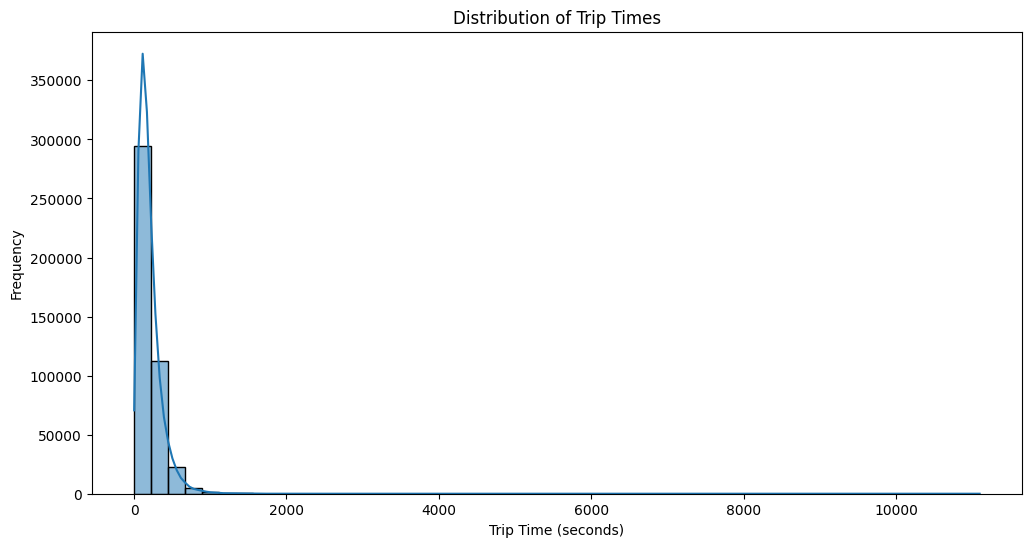

In [43]:
# 1. Average Trip Time by Hour of Day
hourly_avg = trips.groupby('hour')['total_trip_time'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg, x='hour', y='total_trip_time')
plt.title('Average Trip Time by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Trip Time (seconds)')
plt.show()

# 2. Trip Volume by Day of Week
day_volume = trips['week_day'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
day_volume.plot(kind='bar')
plt.title('Trip Volume by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Trips')
plt.show()

# 3. Top 10 Busiest Pickup Locations
top_pickup = trips['PULocationID'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_pickup.plot(kind='bar')
plt.title('Top 10 Busiest Pickup Locations')
plt.xlabel('PULocationID')
plt.ylabel('Number of Pickups')
plt.show()

# 4. Average Trip Time by Weather Condition
weather_avg = trips.groupby('weather_condition_code')['total_trip_time'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
weather_avg.plot(kind='bar')
plt.title('Average Trip Time by Weather Condition')
plt.xlabel('Weather Condition Code')
plt.ylabel('Average Trip Time (seconds)')
plt.show()

# 5. Heatmap of Trip Volume by Hour and Day of Week
pivot = trips.pivot_table(values='total_trip_time', index='week_day', columns='hour', aggfunc='count')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title('Trip Volume Heatmap by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.show()

# 6. Average Trip Time: Holiday vs Non-Holiday
holiday_avg = trips.groupby('is_holiday')['total_trip_time'].mean()
plt.figure(figsize=(8, 6))
holiday_avg.plot(kind='bar')
plt.title('Average Trip Time: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Trip Time (seconds)')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

# 7. Distribution of Trip Times
plt.figure(figsize=(12, 6))
sns.histplot(trips['total_trip_time'], kde=True, bins=50)
plt.title('Distribution of Trip Times')
plt.xlabel('Trip Time (seconds)')
plt.ylabel('Frequency')
plt.show()

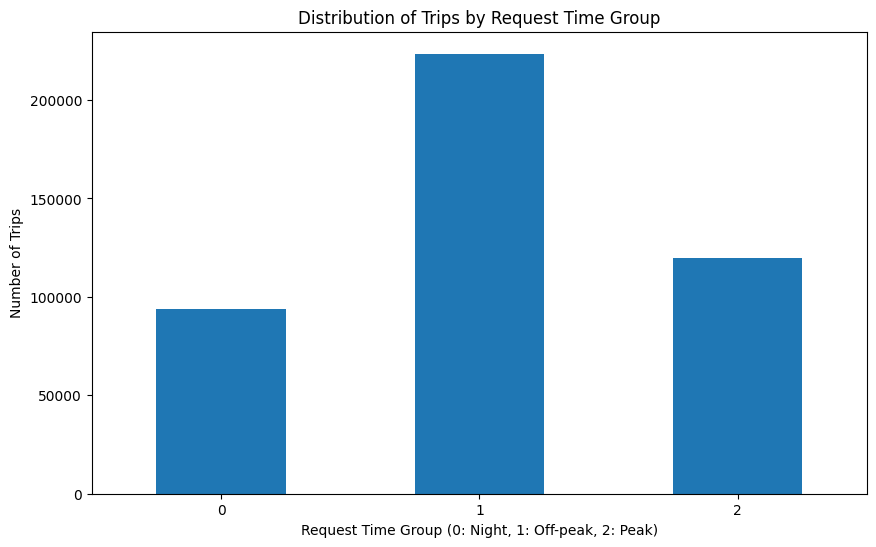

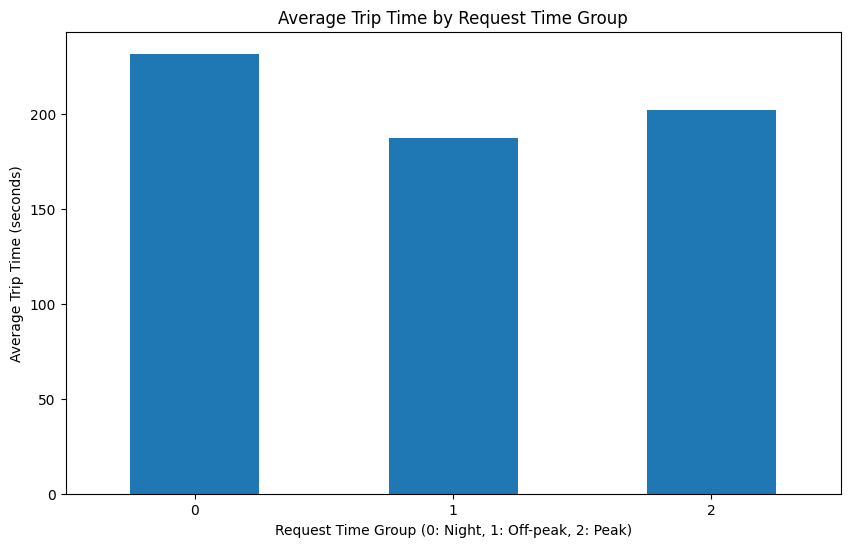

<Figure size 1000x600 with 0 Axes>

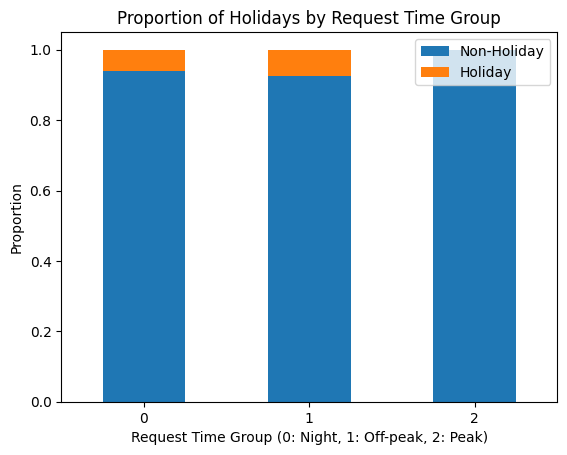

<Figure size 1000x600 with 0 Axes>

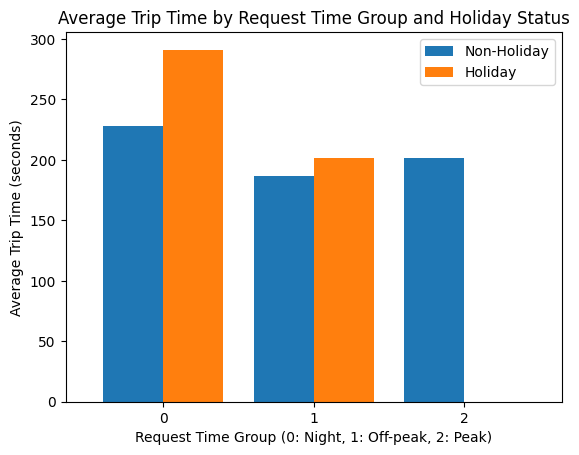

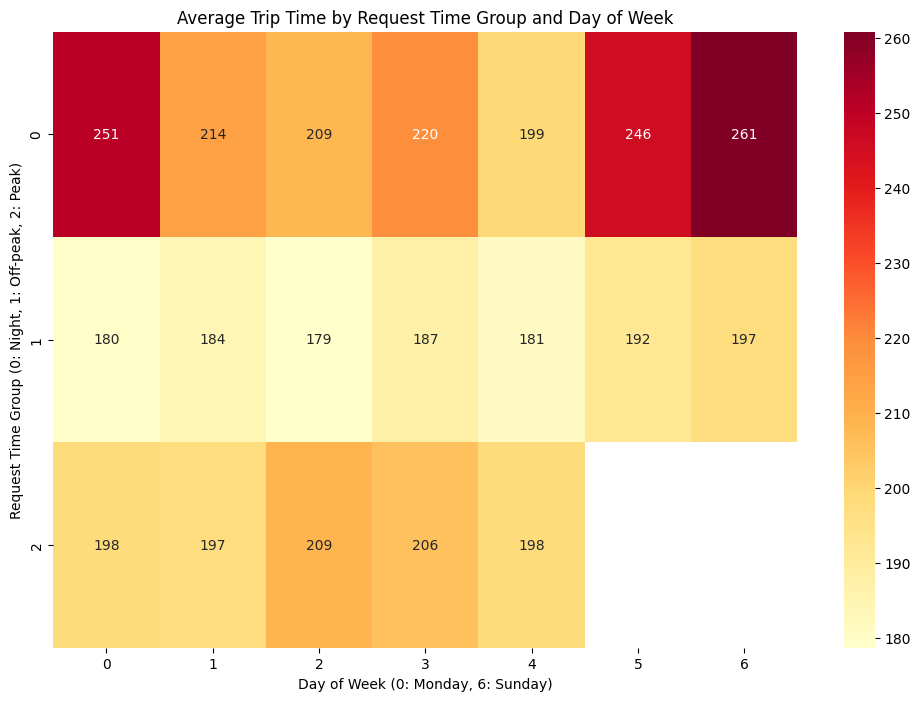

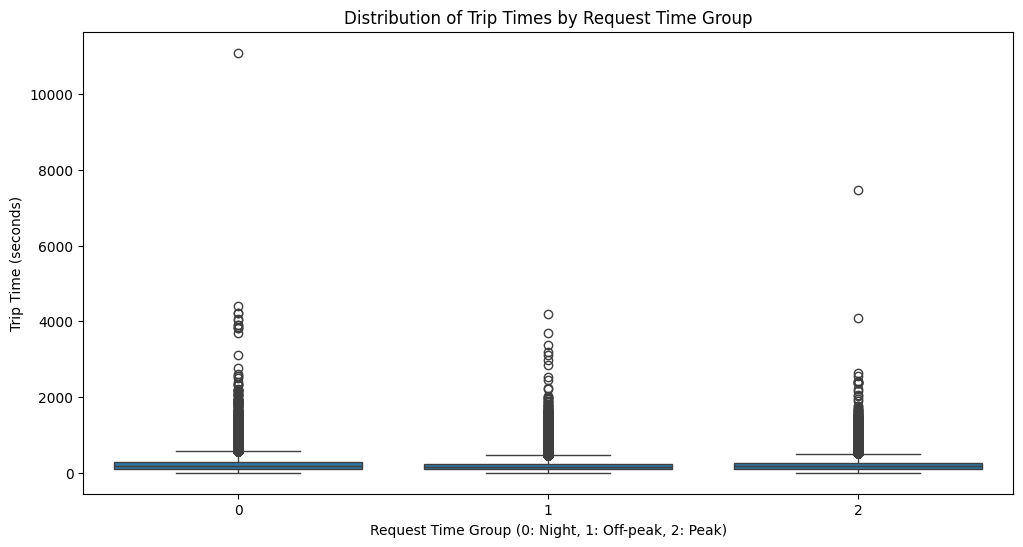

                       count        mean         std  min    25%    50%  \
request_time_group                                                        
0                    93683.0  231.553953  186.782121  4.0  113.0  187.0   
1                   223514.0  187.429888  145.371222  2.0   91.0  154.0   
2                   119611.0  201.810628  153.415470  2.0   99.0  167.0   

                      75%      max  
request_time_group                  
0                   298.0  11095.0  
1                   243.0   4191.0  
2                   263.0   7477.0  

Percentage of trips in each request_time_group:
request_time_group
1    51.169850
2    27.382969
0    21.447180
Name: proportion, dtype: float64


In [45]:
# Function to analyze request_time_group
def analyze_request_time_group(df):
    # 1. Distribution of trips by request_time_group
    plt.figure(figsize=(10, 6))
    trips['request_time_group'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Trips by Request Time Group')
    plt.xlabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=0)
    plt.show()

    # 2. Average trip time by request_time_group
    avg_trip_time = trips.groupby('request_time_group')['total_trip_time'].mean()
    plt.figure(figsize=(10, 6))
    avg_trip_time.plot(kind='bar')
    plt.title('Average Trip Time by Request Time Group')
    plt.xlabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.ylabel('Average Trip Time (seconds)')
    plt.xticks(rotation=0)
    plt.show()

    # 3. Relationship between request_time_group and is_holiday
    holiday_time_group = pd.crosstab(trips['request_time_group'], df['is_holiday'], normalize='index')
    plt.figure(figsize=(10, 6))
    holiday_time_group.plot(kind='bar', stacked=True)
    plt.title('Proportion of Holidays by Request Time Group')
    plt.xlabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.ylabel('Proportion')
    plt.legend(['Non-Holiday', 'Holiday'])
    plt.xticks(rotation=0)
    plt.show()

    # 4. Average trip time by request_time_group and is_holiday
    avg_trip_time_holiday = trips.groupby(['request_time_group', 'is_holiday'])['total_trip_time'].mean().unstack()
    plt.figure(figsize=(10, 6))
    avg_trip_time_holiday.plot(kind='bar', width=0.8)
    plt.title('Average Trip Time by Request Time Group and Holiday Status')
    plt.xlabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.ylabel('Average Trip Time (seconds)')
    plt.legend(['Non-Holiday', 'Holiday'])
    plt.xticks(rotation=0)
    plt.show()

    # 5. Heatmap of average trip time by request_time_group and day of week
    pivot = df.pivot_table(values='total_trip_time', index='request_time_group', columns='week_day', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Average Trip Time by Request Time Group and Day of Week')
    plt.xlabel('Day of Week (0: Monday, 6: Sunday)')
    plt.ylabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.show()

    # 6. Box plot of trip times by request_time_group
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='request_time_group', y='total_trip_time', data=trips)
    plt.title('Distribution of Trip Times by Request Time Group')
    plt.xlabel('Request Time Group (0: Night, 1: Off-peak, 2: Peak)')
    plt.ylabel('Trip Time (seconds)')
    plt.show()

# Run the analysis
analyze_request_time_group(trips)

# Print some summary statistics
print(trips.groupby('request_time_group')['total_trip_time'].describe())

# Calculate the percentage of trips in each request_time_group
time_group_percentages = trips['request_time_group'].value_counts(normalize=True) * 100
print("\nPercentage of trips in each request_time_group:")
print(time_group_percentages)